In [1]:
import sys
import os
import shutil
import errno
from glob import glob
from decimal import Decimal
from pylab import *
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
import imageio
from IPython.display import set_matplotlib_formats
from ast import literal_eval

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
cmap=plt.cm.viridis

# Data Gathering Functions

In [2]:
def get_parameters(dir_):
    
    
    names, values = [], []       
    file = open(dir_ + "input.txt", "rt")

    for line in file:
        if not line.rstrip(): continue
            
        line = line.rstrip("\n")
        if(line.isupper()): names.append(line)
        else: values.append(line.split(" "))
            
    for x in range(len(values)):
        if (len(values[x]) == 1):
            try: values[x] = float(values[x][0])
            except: values[x] = values[x][0]
        else: 
            for y in range(len(values[x])): values[x][y] = float(values[x][y])
                
    return [names, values]    


def get_values(dictionary, name):
    try:
        names = dictionary[0]
        values = dictionary[1]
        index = names.index(name)
        return values[index]
    except:
        return 0    
    


def get_trajectory_data(dir_):
    file = open(dir_ + "trajectories.txt", "rt")
    NAMES = (file.readline().rstrip("\n")).split(" ")
    NAMES = [string for string in NAMES if string != ""]

    trajectory_data = pd.read_table(file, comment="#",skiprows=0, delim_whitespace=True, names=NAMES)
    return trajectory_data



def get_evolve_data(time_file):
    file = open(time_file, "rt")
    NAMES = (file.readline().rstrip("\n")).split(" ")
    NAMES = [string for string in NAMES if string != ""]

    evolve_data = pd.read_table(file, comment="#",skiprows=0, delim_whitespace=True, names=NAMES)
    return evolve_data

# Plotting Functions

In [17]:
def plot_trajcetory_data(dir_, trajectory_data, parameters):
    num_trajectories = len(trajectory_data.columns)-1
    
    num_rows = len(trajectory_data)
    grid_dim = get_values(parameters, "GRID_LENGTH")
    path = dir_ + "/figures/trajectory_plots"
    if not os.path.exists(path):
        os.makedirs(path)  
        
    for x in range(num_rows):
        row = trajectory_data.iloc[x, :]
        time = row[0]

        plt.figure()
        plt.ylabel("y")
        plt.xlabel("x")
        plt.xlim(0,grid_dim-1)
        plt.ylim(0,grid_dim-1)
        plt.title("t: " + str(round(time, 4)))
        
        positions = np.array([literal_eval(s) for s in list((row.iloc[1:]).values)]).T  
        plt.scatter(positions[0], positions[1], c='black', s= 150)

        plt.savefig(dir_ + "/figures/trajectory_plots/t_" + str(time) + ".jpg")
        plt.show()
        plt.close()
        
        
        
     
    
def plot_evolve_data(dir_, evolve_data, parameters, time):
    grid_dim = int(get_values(parameters, "GRID_LENGTH"))
    
    positions = np.array([literal_eval(s) for s in list((evolve_data["coordinates"]))]).T  
    positions = np.array([literal_eval(s) for s in list((evolve_data["coordinates"]))]).T  
    velocities = np.array([literal_eval(s) for s in list((evolve_data["velocities"]))]).T 
    
    X = (positions[0]).reshape(grid_dim,grid_dim)
    Y = (positions[1]).reshape(grid_dim,grid_dim)
    U = (velocities[0]).reshape(grid_dim,grid_dim)
    V = (velocities[1]).reshape(grid_dim,grid_dim)
    R = np.array(evolve_data["rho"]).reshape(grid_dim,grid_dim) 
    Q = np.array(evolve_data["Q"]).reshape(grid_dim,grid_dim) 
    
    path = dir_ + "/figures/evolve_plots"
    if not os.path.exists(path):
        os.makedirs(path)  
        
    plt.figure()
    plt.xlim(-0.5,grid_dim-0.5)
    plt.ylim(-0.5,grid_dim-0.5)
    plt.title("t: " + str(time))

    plt.quiver(X, Y, U, V, edgecolor='k', facecolor='Black', linewidth=.5)
    plt.imshow(R[::-1],extent=[0,grid_dim,0,grid_dim], cmap=cmap, alpha=0.5)#,vmin=0, vmax=5,norm=norm, cmap=cmap)
    plt.colorbar(label = 'denisty')

    plt.savefig(dir_ + "/figures/evolve_plots/t_" + str(time) + ".jpg")
    plt.show()
    plt.close()
    
    path = dir_ + "/figures/denisty_plots"
    if not os.path.exists(path):
        os.makedirs(path)  
        
    plt.figure()
    plt.title("t: " + str(time))
    plt.ylabel("y")
    plt.xlabel("x")  
    #plt.imshow(Q.T[::-1],extent=[0,grid_dim,0,grid_dim], cmap=cmap,vmin=-0.05, vmax=0.005)#,norm=norm, cmap=cmap)
    plt.imshow(Q.T[::-1],extent=[0,grid_dim,0,grid_dim], cmap=cmap)#,vmin=-0.05, vmax=0.005)#,norm=norm, cmap=cmap)
    plt.colorbar(label = 'Q')
    plt.show()    
    
def plot_combined_data(dir_, evolve_data, trajectory_data,parameters, time):

    grid_dim = int(get_values(parameters, "GRID_LENGTH"))
    time_step_save = get_values(parameters, "TIME_STEP_SAVE")
    
    num_rows = len(trajectory_data)
        
    positions = np.array([literal_eval(s) for s in list((evolve_data["coordinates"]))]).T  
    velocities = np.array([literal_eval(s) for s in list((evolve_data["velocities"]))]).T 
   
    X = (positions[0]).reshape(grid_dim,grid_dim)
    Y = (positions[1]).reshape(grid_dim,grid_dim)
    U = (velocities[0]).reshape(grid_dim,grid_dim)
    V = (velocities[1]).reshape(grid_dim,grid_dim)
    R = np.array(evolve_data["rho"]).reshape(grid_dim,grid_dim) 
   
    row = trajectory_data.iloc[int(time/time_step_save), :]
    t_positions = np.array([literal_eval(s) for s in list((row.iloc[1:]).values)]).T      

    path = dir_ + "/figures/combined_plots"
    if not os.path.exists(path):
        os.makedirs(path)  
        
    plt.figure()
    plt.xlim(-0.5,grid_dim-0.5)
    plt.ylim(-0.5,grid_dim-0.5)
    plt.title("t: " + str(time))
    
    #plt.quiver(X, Y, U, V, R, alpha=.5)
    plt.quiver(X, Y, U, V, edgecolor='k', facecolor='Black', linewidth=.5)
    plt.imshow(R[::-1],extent=[0,grid_dim,0,grid_dim], cmap=cmap, alpha=0.5)#,vmin=0, vmax=0.002)#norm=norm)
    plt.colorbar(label = 'denisty')

    plt.scatter(t_positions[0], t_positions[1], c='black', s =150)

    plt.savefig(dir_ + "/figures/combined_plots/t_" + str(time) + ".jpg")
    plt.show()
    plt.close()


    
    
    
    
def make_plots(dir_):
    parameters = get_parameters(dir_)
    total_time, time_step_save = get_values(parameters, "TOTAL_TIME"), get_values(parameters, "TIME_STEP_SAVE")
    trajectory_data = get_trajectory_data(dir_)
#     plot_trajcetory_data(dir_, trajectory_data, parameters)
    
#     time = 0
#     for time_file in glob(dir_ + 'time*.txt'):
#         evolve_data = get_evolve_data(time_file)
#         plot_evolve_data(dir_, evolve_data, parameters, time)
#         time = round(time+time_step_save,4)

    time =0  
    files = glob(dir_ + 'time*.txt')
    index = []
    for item in files: index.append(float((item.split("\\time_")[1]).split(".txt")[0]))
    print(parameters)
    files = np.array(files)[np.argsort(index)]
    for time_file in files:
        evolve_data = get_evolve_data(time_file)
        plot_combined_data(dir_, evolve_data, trajectory_data,parameters, time)
        time = round(time+time_step_save,4)


# Video Generation, probably using http://imageio.github.io/ to generate a video from a bunch of images

In [18]:
def make_videos(dir_):
    evolve_plots = sorted(glob(dir_ + "/figures/evolve_plots/*.jpg"))
    trajectory_plots = sorted(glob(dir_ + "/figures/trajectory_plots/*.jpg"))
    combined_plots = glob(dir_ + "/figures/combined_plots/*.jpg")
    
    index = []
    for item in combined_plots: index.append(float((item.split("\\t_")[1]).split(".jpg")[0]))
    combined_plots = np.array(combined_plots)[np.argsort(index)]

    path = dir_ + "/videos/"
    if not os.path.exists(path):
        os.makedirs(path)  
        

    e_plots, t_plots, c_plots = [], [], []
    
# #     for e_plot in evolve_plots:
# #         e_plots.append(imageio.imread(e_plot))
# #     imageio.mimsave(dir_ + 'videos/evolve.gif', e_plots, duration = 0.05)
    
# #     for t_plot in trajectory_plots:
# #         t_plots.append(imageio.imread(t_plot))
# #     imageio.mimsave(dir_ + 'videos/trajectory.gif', t_plots, duration = 0.05)
    
    for c_plot in combined_plots:
        c_plots.append(imageio.imread(c_plot))
    imageio.mimsave(dir_ + 'videos/combined.gif', c_plots, duration = 0.5)

# 'Main'

[['GRID_LENGTH', 'SPATIAL_DIMENSION', 'NUMBER_OF_PARTICLES', 'MASS', 'TOTAL_TIME', 'TIME_STEP', 'POINT_SPACING', 'DEGREE_OF_FIT', 'NUMBER_OF_TRAJECTORIES', 'INITIAL_TRAJECTORIES', 'INITIAL_VELOCITY_FUNCTION', 'INITIAL_DENSITY_FUNCTION', 'POTENTIAL_FUNCTION', 'WRITE_FOLDER', 'TIME_STEP_SAVE'], [20.0, 2.0, 1.0, 1.0, 10.0, 0.001, 1.0, 2.0, 4.0, [12.5, 9.5, 6.5, 9.5, 9.5, 12.5, 9.5, 6.5], 4.0, 4.0, 4.0, 'inf_circular_well', 0.1]]


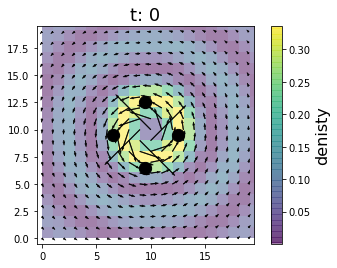

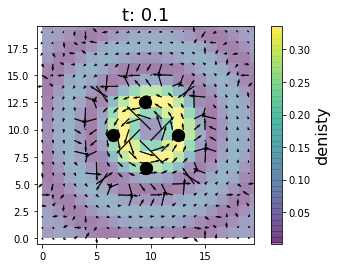

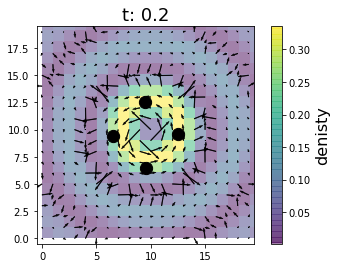

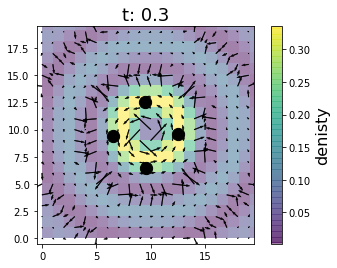

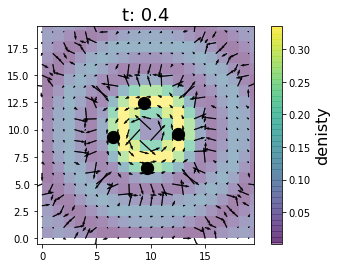

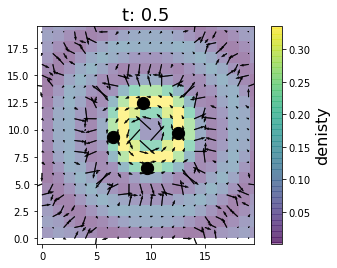

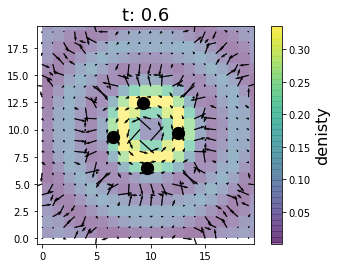

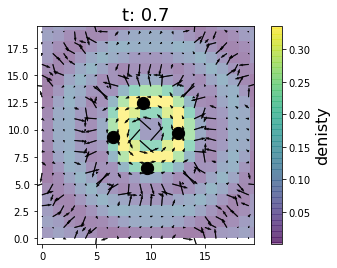

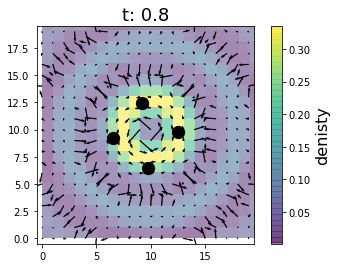

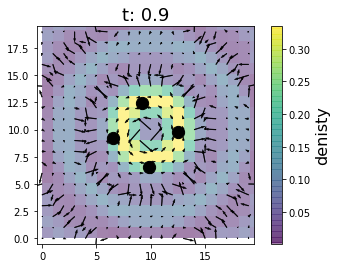

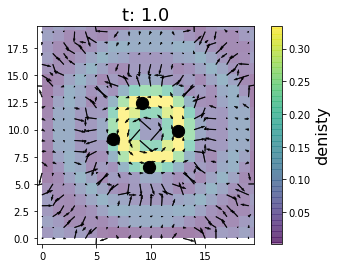

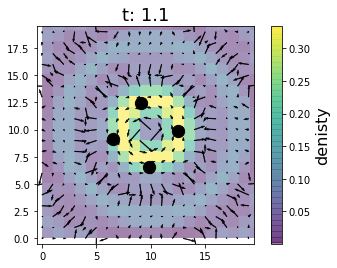

In [20]:
# dirs = ["../data/holland_ex4.11_pg169/"]
#dirs = ["../data/2d_harmonic_oscillator/"]
dirs = ["../data/inf_circular_well/"]

for dir_ in dirs:    
    make_plots(dir_)
    #make_videos(dir_)

## 